In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_dir = '../sat2/train'
val_dir = '../sat2/val'

im_size = 224
batch_size = 32
num_classes = 5
num_epochs = 30
lr = 0.0005

In [4]:
train_transforms = transforms.Compose([                         # 定义训练数据的预处理操作序列
    transforms.Resize((im_size, im_size)),                      # 将图片缩放为统一尺寸（例如 224x224）
    transforms.RandomHorizontalFlip(),                          # 以一定概率进行水平翻转（数据增强）
    transforms.ToTensor(),                                      # 转为张量（Tensor），并归一化到 [0,1]
])

val_transforms = transforms.Compose([                           # 定义验证数据的预处理操作（不增强）
    transforms.Resize((im_size, im_size)),                      # 缩放为统一尺寸
    transforms.ToTensor(),                                      # 转为张量并归一化
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)  # 按文件夹读取训练数据，并应用预处理
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)        # 按文件夹读取验证数据，并应用预处理

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)  # 加载训练数据，打乱顺序，多线程提速
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)     # 加载验证数据，不打乱顺序，多线程提速

In [5]:
class BasicBlock(nn.Module):
    expansion = 1  # 输出通道不变

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample  # 用于匹配维度

    def forward(self, x):
        identity = x if self.downsample is None else self.downsample(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = self.relu(out)
        return out

In [6]:
class BottleNeck(nn.Module):
    expansion = 4  # 输出通道为输入的4倍

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1,stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * 4, kernel_size=1,stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample  # 用于匹配维度

    def forward(self, x):
        identity = x if self.downsample is None else self.downsample(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += identity
        out = self.relu(out)
        return out

In [7]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=5):
        super().__init__()
        self.in_channels = 64  # 第一层输入通道数

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7,stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 每个 layer 对应一个 stage
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # 全局平均池化
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            # 如果维度不一致，需要下采样
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [8]:
def build_resnet18():
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

def build_resnet50():
    return ResNet(BottleNeck, [3, 4, 6, 3], num_classes=num_classes)

model = build_resnet18().to(device)
# model = build_resnet50().to(device)  # 可切换成ResNet50

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_acc_list = []
val_acc_list = []

In [9]:
for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_acc_list.append(train_acc)

    # 验证
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_acc_list.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")


Epoch [1/30] Train Acc: 0.5651, Val Acc: 0.4457
Epoch [2/30] Train Acc: 0.6698, Val Acc: 0.6486
Epoch [3/30] Train Acc: 0.6962, Val Acc: 0.7657
Epoch [4/30] Train Acc: 0.7622, Val Acc: 0.6743
Epoch [5/30] Train Acc: 0.7813, Val Acc: 0.7457
Epoch [6/30] Train Acc: 0.8067, Val Acc: 0.7343
Epoch [7/30] Train Acc: 0.8232, Val Acc: 0.7886
Epoch [8/30] Train Acc: 0.8429, Val Acc: 0.7943
Epoch [9/30] Train Acc: 0.8578, Val Acc: 0.8200
Epoch [10/30] Train Acc: 0.8848, Val Acc: 0.8400
Epoch [11/30] Train Acc: 0.8921, Val Acc: 0.8029
Epoch [12/30] Train Acc: 0.9022, Val Acc: 0.8343
Epoch [13/30] Train Acc: 0.9165, Val Acc: 0.8629
Epoch [14/30] Train Acc: 0.9216, Val Acc: 0.8829
Epoch [15/30] Train Acc: 0.9378, Val Acc: 0.8943
Epoch [16/30] Train Acc: 0.9400, Val Acc: 0.9229
Epoch [17/30] Train Acc: 0.9422, Val Acc: 0.9143
Epoch [18/30] Train Acc: 0.9524, Val Acc: 0.8971
Epoch [19/30] Train Acc: 0.9540, Val Acc: 0.8943
Epoch [20/30] Train Acc: 0.9517, Val Acc: 0.8571
Epoch [21/30] Train Acc: 0.96

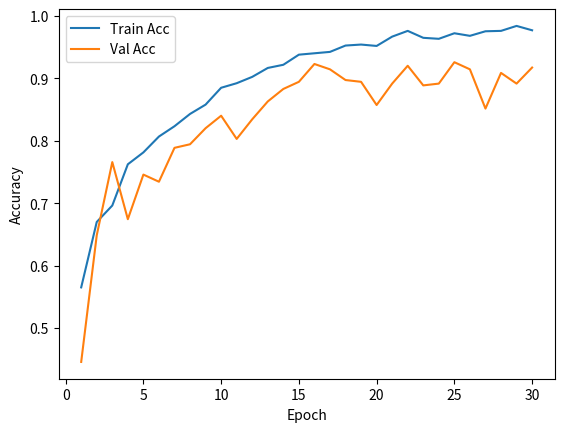

In [10]:
plt.plot(range(1, num_epochs + 1), train_acc_list, label='Train Acc')
plt.plot(range(1, num_epochs + 1), val_acc_list, label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [11]:
torch.save(model.state_dict(), "ResNet18.pth")